<div class="pull-left">
    
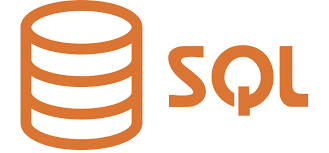
    
</div>

Требуется написать несколько SQL-запросов в Jupyter Notebook.\
База данных StackOverflow — сервис вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.
Работаем с версией базы, где хранятся данные о постах за 2008 год, но в таблицах будет информация и о более поздних оценках, которые эти посты получили.

<div class="pull-right">
    
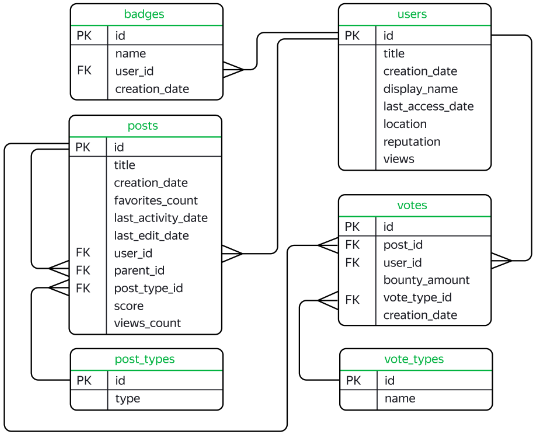
    
</div>

ER-диаграмма:\
`badges` - хранит информацию о значках, которые присуждаются за разные достижения; например, пользователь, правильно ответивший на большое количество вопросов про PostgreSQL, может получить значок postgresql;\
`post_types` - тип постов (Question, Answer);\
`posts`;\
`users`;\
`vote_types` - типы голосов; это метка, которую пользователи ставят посту (UpMod, DownMod, Close, Offensive, Spam);\
`votes` - голоса за посты.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

# Конфигурация для подключения к базе данных

Эта база данных (`data-analyst-advanced-sql`)содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student',                         # имя пользователя
    'pwd':  'Sdf4$2;d-d30pp',                            # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', # хост
    'port':  6432,                                       # порт подключения
    'db':   'data-analyst-advanced-sql'                  # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string) # создание подключения

Проверка работы подключения.

In [4]:
# таблицы представленные в схеме
query = '''
SELECT *
FROM   pg_catalog.pg_tables
WHERE  pg_catalog.pg_tables.schemaname = 'stackoverflow'
'''

print(*pd.read_sql_query(query, con=engine)['tablename'].values)

badges post_types posts users vote_types votes


In [5]:
# одна из таблиц
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

pd.read_sql_query(query, con=engine) 

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

**Решение 1 (с оконной функцией)**

In [6]:
query = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date)::date AS month_date,
                SUM(views_count) OVER(PARTITION BY DATE_TRUNC('month', creation_date)) AS total_views
FROM   stackoverflow.posts
WHERE  EXTRACT(YEAR FROM creation_date) = 2008
ORDER BY total_views DESC;
'''

df = pd.read_sql_query(query, con=engine)
df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Решение 2 (с группировкой)**

In [7]:
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) AS total_views
FROM   stackoverflow.posts
WHERE  EXTRACT(YEAR FROM creation_date) = 2008
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY total_views DESC;
'''

df = pd.read_sql_query(query, con=engine)
df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

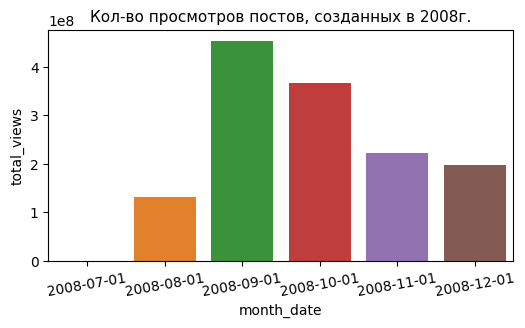

In [8]:
plt.figure(figsize=(6,3))
sns.barplot(data=df.sort_values(by='month_date'), x='month_date', y='total_views')\
   .tick_params(axis='x', labelrotation=10)
plt.title('Кол-во просмотров постов, созданных в 2008г.', fontsize=11); plt.show()

<a id= 'intro'></a>
Ресурс StackOverflow был [создан](https://ru.wikipedia.org/wiki/Stack_Overflow#:~:text=%D0%9D%D0%B0%D1%87%D0%B0%D0%BB%D0%BE%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B-,%D0%B0%D0%B2%D0%B3%D1%83%D1%81%D1%82%202008,-%D0%A2%D0%B5%D0%BA%D1%83%D1%89%D0%B8%D0%B9%20%D1%81%D1%82%D0%B0%D1%82%D1%83%D1%81) в августе 2008г.
В сентябре получил пик просморов, так как люди ознакамливались с новым продуктом. Далее число просмотров начало плавно снижаться до стабильного уровня постоянных пользователей.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [9]:
query = '''
SELECT u.display_name,
       COUNT(DISTINCT user_id)
FROM stackoverflow.users AS u
INNER JOIN stackoverflow.posts AS p ON u.id=p.user_id
INNER JOIN stackoverflow.post_types AS pt ON p.post_type_id=pt.id
WHERE type = 'Answer'
  AND p.creation_date-u.creation_date <= '1 month'
GROUP BY u.display_name
HAVING COUNT(p.id)>100            -- считаем кол-во постов у одного имени (а не у одного id-пользователя)
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


Какие аномалии наблюдаются в данных? О чём они говорят?

In [10]:
# кол-во уникальных значений в "count"
df['count'].value_counts()

1     57
16     3
3      2
10     2
15     2
29     2
5      1
7      1
8      1
9      1
11     1
12     1
19     1
21     1
Name: count, dtype: int64

In [11]:
# число уникальных имен пользователей
df.display_name.nunique()

76

In [12]:
# уникальные имена пользователей
df.display_name.unique()

array(['1800 INFORMATION', 'Adam Bellaire', 'Adam Davis', 'Adam Liss',
       'Alan', 'Amy B', 'Ben Hoffstein', 'Brian', 'Cade Roux', 'CesarB',
       'Chris', 'ConcernedOfTunbridgeWells', 'Craig', 'Dale Ragan', 'Dan',
       'Eric Z Beard', 'Espo', 'FlySwat', 'Franci Penov', 'GEOCHET',
       'GateKiller', 'Greg', 'Gulzar Nazim', 'Ilya Kochetov',
       'James Curran', 'Jim', 'Joe', 'Joel Coehoorn',
       'Johannes Schaub - litb', 'John Millikin', 'Jon Limjap',
       'Jon Skeet', 'Jorge Ferreira', 'Josh', 'Keith', 'Kevin', 'Kibbee',
       'Konrad Rudolph', 'Lasse Vågsæther Karlsen', 'Marc Gravell',
       'Mark', 'Mark Cidade', 'Mark Harrison', 'Matt', 'Matt Hamilton',
       'Michael Burr', 'Michael Stum', 'Mitchel Sellers', 'Nick',
       'Norman Ramsey', 'Oli', 'Orion Edwards', 'Paul Nathan', 'PhiLho',
       'Rob', 'Rob Cooper', 'Rob Walker', 'Ryan', 'S.Lott', 'Sklivvz',
       'Steven A. Lowe', 'TheSmurf', 'Tom', 'Vilx-', 'Vinko Vrsalovic',
       'aku', 'anjanb', 'dkretz', 'f

Есть 19 популярных имён, каждое из которых принадлежит более чем одному пользователю. А 57 имён принадлежат отдельным user_id.

Среди имён есть неформатное значение "1800 INFORMATION". Также есть странные значения: 'aku', 'anjanb', 'dkretz', 'frankodwyer', 'gbjbaanb', 'leppie', 'lomaxx', 'mattlant', 'paxdiablo', 'tzot'.\
Необходимо вместе с бизнесом разобраться откуда мог попасть этот текст, уточнить есть ли правила записи имён (допустимо ли записывать себя под любым набором букв).

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

**Решение 1 (без объединения таблиц)**

In [13]:
query = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date) AS month,
                  COUNT(id) OVER(PARTITION BY DATE_TRUNC('month',creation_date))
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008                        -- фильтр по году
  AND user_id IN (SELECT id                                          -- фильтр по пользователям зарегистрировавшимся в сентябре
                  FROM   stackoverflow.users
                  WHERE  DATE_TRUNC('month',creation_date) = '2008-09-01')
  AND user_id IN (SELECT user_id                                     -- фильтр по пользователям запостивших в декабре
                  FROM   stackoverflow.posts
                  WHERE  DATE_TRUNC('month',creation_date) = '2008-12-01')
ORDER BY month DESC
'''

df = pd.read_sql_query(query, con=engine)
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


**Решение 2 (с объединением таблиц)**

In [14]:
query = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date)::date AS month,
                  COUNT(id) OVER(PARTITION BY DATE_TRUNC('month',creation_date))
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008  -- фильтр по году
  AND user_id IN (SELECT DISTINCT p.user_id  -- фильтр по пользователям зарегистрировавшимся в сентябре и запостивших в декабре
                  FROM   stackoverflow.posts AS p
                  INNER  JOIN stackoverflow.users AS u ON p.user_id=u.id
                  WHERE  DATE_TRUNC('month', u.creation_date) = '2008-09-01'
                    AND  DATE_TRUNC('month', p.creation_date) = '2008-12-01')
ORDER BY month DESC
'''

df = pd.read_sql_query(query, con=engine)
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

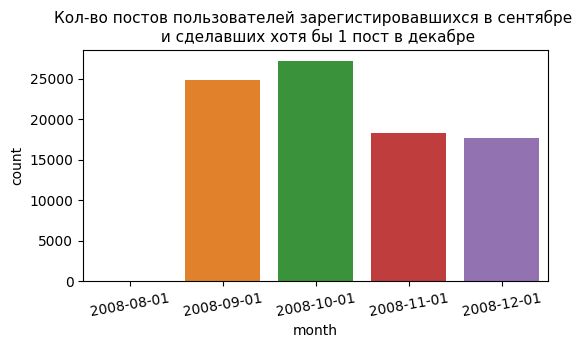

In [15]:
plt.figure(figsize=(6,3))
sns.barplot(data=df.sort_values(by='month'), x='month', y='count')\
   .tick_params(axis='x', labelrotation=10)
plt.title('Кол-во постов пользователей зарегистировавшихся в сентябре \n и сделавших хотя бы 1 пост в декабре', fontsize=11); plt.show()

По условию задачи были отобраны пользователи зарегистрировавшиеся в сентябре. При этом в результате запроса, что они якобы писали посты в августе.<br>
Данная аномалия может быть связана с трансформированием времени из одного часового пояса в другой, или из формата без часовых поясов в формат с часовыми поясами (или наоборот).<br>
Может быть опечатка заполняющего форму. МОжет быть ошибка программы (кода) в момент активности пользователя.

Также наблюдаем пик количества постов в октябре. Далее идёт значительный спад и выравнивание. Не уверен, что данная ступень между октябрём и ноябрём является странностью. Может быть простое снижение интереса к платформе после первых месяцев пользования. Так сказать, попробовали новую игрушку, оттестировали возможности, сбили аскому. А далее вышли на стабильный уровень пользования знакомым продуктом.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [16]:
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM   stackoverflow.posts
    
'''

df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [17]:
query = '''

SELECT DISTINCT user_id,
                AVG(count) OVER(PARTITION BY user_id) AS avg_daily              -- среднее кол-во постов в день у пользователя
FROM   (SELECT DISTINCT user_id,
                        creation_date::date,
                        COUNT(id) OVER(PARTITION BY user_id, creation_date::date)       -- кол-во постов в день у пользователя
                        FROM   stackoverflow.posts
        WHERE  DATE_TRUNC('month',creation_date)='2008-08-01'                                        -- отбор постов за август
          AND  user_id IN (SELECT user_id                  -- фильтр по пользователям, опубликовшим более 120 постов за август
                           FROM   stackoverflow.posts
                           WHERE  DATE_TRUNC('month',creation_date)='2008-08-01'
                           GROUP  BY user_id
                           HAVING COUNT(id)>120)) AS pre_table
ORDER BY avg_daily
'''

df = pd.read_sql_query(query, con=engine)
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [18]:
query = '''
SELECT ROUND(AVG(count)) AS result
FROM   (SELECT DISTINCT user_id,                             -- перечень пользователей с количеством дней взаимодействия
                        COUNT(*) OVER(PARTITION BY user_id)
        FROM   (SELECT DISTINCT user_id,                     -- перечень пользователей с датами взаимодействия с 1 по 7.12.08
                                creation_date::date
                FROM  stackoverflow.posts
                WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07') AS pre_table) AS pre_table_2

'''

df = pd.read_sql_query(query, con=engine)
df

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В период с 1 по 7 декабря 2008 г. пользователи взаимодействовали с платформой в среднем 2 дня.\
Какие ещё можно сделать выводы из этой таблицы в одну явейку?  😄

**Расширенный анализ**

Посмотрим динамику понедельного среднего числа взаимодействия с платформой за весь данный период.

In [19]:
# минимальная дата рассматриваемого периода
query = '''
SELECT MIN(creation_date)
FROM   stackoverflow.posts
'''

df = pd.read_sql_query(query, con=engine)
df

,min
0,2008-07-31 21:42:53


In [20]:
# максимальная дата расматриваемого периода
query = '''
SELECT MAX(creation_date)
FROM   stackoverflow.posts
'''

df = pd.read_sql_query(query, con=engine)
df

,max
0,2008-12-30 23:59:15


Данный период - 5 месяцев. Это около 20 недель.

In [21]:
df = pd.DataFrame(columns=['result'])

for k in range(21):
    query = '''
    SELECT ROUND(AVG(count)) AS result
    FROM   (SELECT DISTINCT user_id,                             -- перечень пользователей с кол.дн. взаимодействия в k-ую нед.
                            COUNT(*) OVER(PARTITION BY user_id)
            FROM   (SELECT DISTINCT user_id,                     -- перечень пользователей с датами взаимод-ия в k-ую неделю
                                    creation_date::date
                    FROM  stackoverflow.posts
                    WHERE creation_date::date BETWEEN (DATE '2008-08-01' +'''+str(k)+'''  * INTERVAL '7 day') 
                                                  AND (DATE '2008-08-01' +'''+str(k+1)+'''* INTERVAL '7 day')) AS pre_table) 
                                                                                                               AS pre_table_2
    '''
    df = pd.concat([df, pd.DataFrame(pd.read_sql_query(query, con=engine).values[0][0], [k], ['result'])])

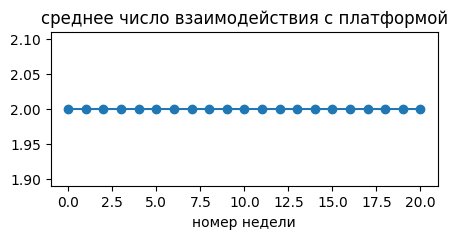

In [22]:
df.plot(figsize=(5,2), xlabel='номер недели', style='o-', legend=False, title='среднее число взаимодействия с платформой') 
plt.show()

Во всём наблюдаемом периоде с августа по декабрь 2008г. еженедельное среднее число взаимодействия с платформой - 2 раза.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [23]:
query = '''
SELECT user_id,
       creation_date,
       LAG(TO_CHAR(creation_date, 'month'),2) OVER(PARTITION BY user_id ORDER BY user_id, creation_date) AS second_last_month
FROM stackoverflow.posts
'''

df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,july
3,1,2008-08-04 02:45:08,july
4,1,2008-08-04 04:31:03,july
...,...,...,...
243791,5696608,2008-12-23 16:00:37,december
243792,5696608,2008-12-23 17:35:09,december
243793,5696608,2008-12-24 01:02:48,december
243794,5696608,2008-12-30 14:34:45,december


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [24]:
query = '''
WITH 

--таблица с пользователями, месяц их 1-ого поста, месяц каждого любого поста (без дублей)
pre_table AS            
  (SELECT DISTINCT user_id,
                  FIRST_VALUE(DATE_TRUNC('month',creation_date)) OVER(PARTITION BY user_id ORDER BY creation_date) AS cohort_dt,
                  DATE_TRUNC('month', creation_date) AS session_date
   FROM   stackoverflow.posts),
   
-- таблица с месяцем 1-ого поста (когорта), месяцем 1-ого или другого поста пользователей из этой когорты, 
-- ... числом пользователей из этой когорты запостивших в этот месяц
pre_table_2 AS
  (SELECT DISTINCT cohort_dt::date,
                   session_date::date,
                   COUNT(*) OVER(PARTITION BY cohort_dt, session_date) AS users_cnt
   FROM pre_table
   ORDER BY cohort_dt, session_date)

-- добавили столбец с числом пользователей из когорты и долю активных пользователей когорты
SELECT *,
                       MAX(users_cnt) OVER(PARTITION BY cohort_dt)            AS cohort_users_cnt,
       ROUND(users_cnt/MAX(users_cnt) OVER(PARTITION BY cohort_dt)::real*100) AS retention_rate
FROM   pre_table_2

'''

df = pd.read_sql_query(query, con=engine)
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.0
1,2008-07-01,2008-08-01,2,3,67.0
2,2008-07-01,2008-09-01,1,3,33.0
3,2008-07-01,2008-10-01,2,3,67.0
4,2008-07-01,2008-11-01,1,3,33.0
5,2008-07-01,2008-12-01,2,3,67.0
6,2008-08-01,2008-08-01,2151,2151,100.0
7,2008-08-01,2008-09-01,1571,2151,73.0
8,2008-08-01,2008-10-01,1275,2151,59.0
9,2008-08-01,2008-11-01,1050,2151,49.0


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [25]:
retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')

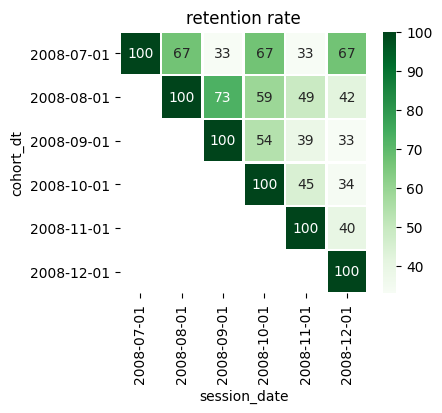

In [26]:
plt.figure(figsize=(4, 3.4))
sns.heatmap(retention, annot=True,fmt='.0f', cmap='Greens', linewidth=1) 
plt.title  ('retention rate'); plt.show()


* За июль анализ не может быть релевантен по причине мизерной выборки (3 человека). Сервис фактически начал работапть только с августа.
* В следующих когортах, начиная с августа, наблюдаем постеменное уменьшение числа активных пользователей (без скачков, как в июле).
* С увеличением "возраста" когорты наблюдаем спад интереса к ресурсу. Например, берём 2-ой месяц и видим снижение активности. Максимальное значение коэффициента в когорте августа. То есть проявлен интерес пользовотелей к новому продукту. Дальше интерес снижается и выходит на постоянный уровень (+/-).

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

In [27]:
query = '''

SELECT *,
       ROUND((post_count::numeric/LAG(post_count) OVER())*100-100,2) AS percentage

-- таблица с месяцем создания постов и количеством созданных постов в этот месяц

FROM (SELECT DISTINCT EXTRACT(MONTH FROM creation_date)::int AS creation_month,
                      COUNT(*) OVER(PARTITION BY EXTRACT(MONTH FROM creation_date)) AS post_count
      FROM stackoverflow.posts
      WHERE DATE_TRUNC('month',creation_date)::date BETWEEN '2008-09-01' AND '2008-12-31') AS pre_table
'''

df = pd.read_sql_query(query, con=engine)
df

,creation_month,post_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

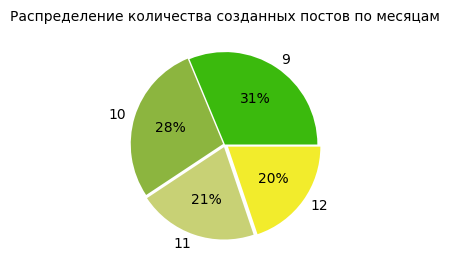

In [28]:
df.set_index('creation_month')['post_count'].plot(kind='pie', autopct='%1.0f%%', label='', explode = (0,0.02,0.03,0.04),
                                                  colors = ['#3bba0d', '#8cb53f', '#c8d175', '#f2ec2c'],
                                                  figsize=(3,3))
plt.title('Распределение количества созданных постов по месяцам', fontsize=10); plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [29]:
query = '''

SELECT DISTINCT EXTRACT(WEEK FROM creation_date)::int AS week_creation,
                MAX(creation_date) OVER(ORDER BY EXTRACT(WEEK FROM creation_date))
FROM stackoverflow.posts
WHERE DATE_TRUNC('month',creation_date) = '2008-10-01'
  AND user_id IN (SELECT user_id                     -- строка с id пользователя, опубликовавшего больше всего постов
                  FROM (SELECT DISTINCT user_id,     -- строка с id пользователя, опубликовавшего больше всего постов... 
                                                     -- ... и кол-во этих постов
                                        COUNT(*) OVER(PARTITION BY user_id) AS post_count
                        FROM stackoverflow.posts
                        ORDER BY post_count DESC
                        LIMIT 1) AS pre_table)

'''

df = pd.read_sql_query(query, con=engine)
df

,week_creation,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
